# Preamble

The following files need to be manually uploaded to run the notebook:
- `LoggedSingleAxisGyroscope.csv`
- `allan_variance.py`

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from allan_variance import plot_allan_deviation, overlapping_allan_deviation

# Undersampling Experimental Data

Now we'll explore the effects of undersampling data. We'll do this by first assuming that the true view of our sensor is given by the logged data in our data sets.

So, for the `LoggedSingleAxisGyro`, we assume that the best view we could have of the error model of this gyroscope was captured in the measurement experiment where the gyro was sampled at 100 Hz. 

Then, we are limited to undersampling this data by an integer number of delays $N*fs^{-1}$.

In [2]:
#load in our assumed truth
logged_path = "/content/LoggedSingleAxisGyroscope.csv"
sa_df = pd.read_csv(logged_path, names=["Data"])

In [3]:
sa_df.head()

,Data
0,0.14875
1,-0.05250
2,-0.04375
3,0.17500
4,-0.05250


In [4]:
#collect the data into an array
single_axis_data = sa_df["Data"].to_numpy()
#create a row vector of the data
single_axis_data = single_axis_data.reshape(-1, )

In [5]:
#sampling rate (Hz)
Fs = 100

In [6]:
#calculate and plot the overlapping Allan deviation
taus, oadev = overlapping_allan_deviation(single_axis_data, Fs=Fs)

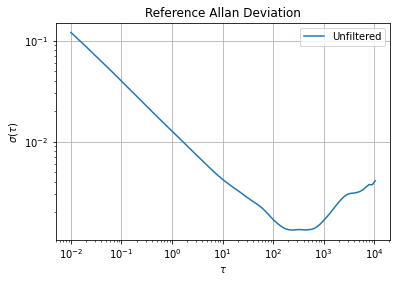

In [7]:
plot_allan_deviation(taus, oadev, label="Unfiltered", title="Reference Allan Deviation")

In [8]:
#every q-th sample of the truth dataset will be used
qth_sample = 2

In [9]:
indices = np.arange(0, len(single_axis_data), qth_sample)
indices[:10]

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [10]:
#select every qth data point
undersampled_data = single_axis_data[indices]

In [11]:
#check that the new dataset is shorter by a factor q
assert len(undersampled_data)==len(single_axis_data)//qth_sample

In [12]:
#calculate the new sampling rate
under_Fs = Fs/qth_sample
under_Fs

50.0

In [13]:
#run the allan deviation again and compare to the reference
under_taus, under_oadev = overlapping_allan_deviation(undersampled_data, under_Fs)

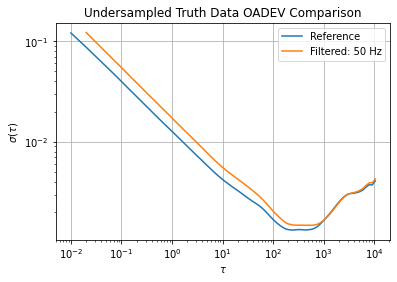

In [14]:
#plot the reference and the undersampled allan deviation manually
#(future versions of `allan_deviation` will have this built in)

plt.loglog(taus, oadev, label="Reference")
plt.loglog(under_taus, under_oadev, label="Filtered: 50 Hz")
plt.grid(b=True)
plt.legend(loc="upper right")
plt.xlabel("$\\tau$")
plt.ylabel("$\sigma(\\tau)$")
plt.title("Undersampled Truth Data OADEV Comparison")
plt.show()
plt.close()

The Allan deviation of the undersampled dataset follows the shape of the reference Allan deviation (slope -1) until it finally meets the reference.

Notice that the undersampled Allan deviation has an increased ARW coefficient. That is, the value of the ADEV at $\tau=1$ for the undersampled data is slightly larger than the reference. 

Let's observe what happens when the degree of undersampling is increased.

Below, we run the same code as above, but with increasing `q` values.

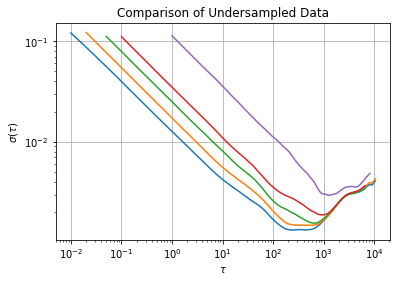

In [15]:
#create a data set using every q-th datapoint in the reference 
q_values = [2,5,10,100]
#q_values = np.arange(1, 100, 10)

#plot the reference ADEV
plt.loglog(taus, oadev, label="Reference: 100 Hz")

#overlay multiple ADEV on a single figure
for q in q_values:
    indices = np.arange(0, len(single_axis_data), q)
    under = single_axis_data[indices]
    #calculate the sampling rate of the undersampled dataset
    new_Fs = Fs/q
    #compute ADEV for the undersampled data
    t, o = overlapping_allan_deviation(under, Fs=new_Fs)
    #plot the ADEV
    plt.loglog(t, o, label="Filtered: {:0.1f} Hz".format(new_Fs))

#plot decorations
plt.grid(b=True)
#plt.legend(loc="upper right")

plt.xlabel("$\\tau$")
plt.ylabel("$\sigma(\\tau)$")
plt.title("Comparison of Undersampled Data")

plt.show()
plt.close()

Again, we see the ARW coefficient increases with decreasing frequency.

In [16]:
#sampling rate for `LoggedSingleAxis`
Fs = 100

In [17]:
q_values = [1,2,5,10,100]

#matrix where column 0 is sampling frequency and column 1 is ARW coefficients
pairs = []

for q in q_values:
    indices = np.arange(0, len(single_axis_data), q)
    under = single_axis_data[indices]
    new_Fs = Fs/q
    t, o = overlapping_allan_deviation(under, Fs=new_Fs)

    #find the value of the ADEV at tau closest to 1
    arw = o[t==t[np.isclose(t, 1, rtol=0.05)]].item()

    pair = [new_Fs, arw]
    pairs.append(pair)

pairs = np.array(pairs)
pairs

array([[1.00000000e+02, 1.25881366e-02],
       [5.00000000e+01, 1.76009453e-02],
       [2.00000000e+01, 2.50388615e-02],
       [1.00000000e+01, 3.48684557e-02],
       [1.00000000e+00, 1.12780720e-01]])

Text(0.5, 1.0, 'Angle Random Walk Coeff. as a Function of Frequency')

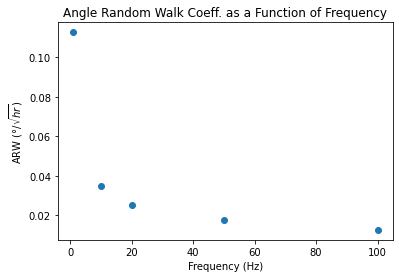

In [18]:
#sampling frequencies
freqs = pairs[:, 0]
#ARW coefficients
arw_coeffs = pairs[:, 1]

#plot ARW vs Freq
plt.scatter(freqs, arw_coeffs)
plt.xlabel("Frequency (Hz)")
plt.ylabel("ARW ($\degree/\sqrt{hr}$)")
plt.title("Angle Random Walk Coeff. as a Function of Frequency")

I'm curious to see what kind of power law this follows.

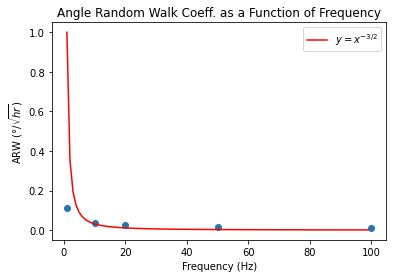

In [19]:
#calculate points of a power law
x = np.arange(1, 100)
y = np.power(x, -1.5)

#plot the estimated best fit curve on top of points
plt.scatter(freqs, arw_coeffs)
plt.plot(x, y, color="red", label="$y=x^{-3/2}$")

#plot decorations
plt.legend(loc="upper right")
plt.xlabel("Frequency (Hz)")
plt.ylabel("ARW ($\degree/\sqrt{hr}$)")
plt.title("Angle Random Walk Coeff. as a Function of Frequency")
plt.show()
plt.close()

The inverse relationship seems to be decently described by $y=x^{-3/2}$. We could use some numerical methods to find the actual best fit curve for this data.

## Undersampling Sensor Data from Lia 2017

In [20]:
df = pd.read_csv("/content/Coupled_1_firsthalf.csv", names=["Sensor", "Laser"])
sensor = df["Sensor"].to_numpy()
taus, oadev = overlapping_allan_deviation(sensor, 1e5)